# Imports and prep

In [8]:
!pip install nltk tqdm pandas scikit-learn matplotlib -q

In [26]:
import torch
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
# Upload the dataset CSV from your cloned repo into Google Colab
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


# Data Preprocessing

In [24]:
import pandas as pd

df = pd.read_csv("IMDB Dataset.csv") # If running locally, ignore the cell above and change this path
print(df.shape)
print(df.head())

(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [11]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df = df[['review', 'label']]
print(df.head())

                                              review  label
0  One of the other reviewers has mentioned that ...      1
1  A wonderful little production. <br /><br />The...      1
2  I thought this was a wonderful way to spend ti...      1
3  Basically there's a family where a little boy ...      0
4  Petter Mattei's "Love in the Time of Money" is...      1


In [12]:
train_df = df.sample(frac=0.5, random_state=123)
test_df  = df.drop(train_df.index)

print(train_df.shape, test_df.shape)

(25000, 2) (25000, 2)


In [28]:
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter

def clean_text(text):
    """Lowercase and remove punctuation/special characters."""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text


def tokenize(text):
    """Tokenize into individual words."""
    return word_tokenize(clean_text(text))


def build_vocab(texts, max_vocab=10000):
    """
    Build a vocabulary of the top 10,000 most frequent words.
    Returns vocab index with word mapped to idx
    """
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    most_common = counter.most_common(max_vocab - 2)  # reserves 2 spaces for PAD/UNK
    word_to_index = {"<PAD>": 0, "<UNK>": 1}
    for i, (word, _) in enumerate(most_common, start=2):
        word_to_index[word] = i
    return word_to_index


def encode_review(text, word_to_index):
    """Convert tokens in a review to integer IDs using the vocab."""
    tokens = tokenize(text)
    return [word_to_index.get(tok, 1) for tok in tokens]  # 1 = <UNK>


def pad_truncate(seq, seq_len): # will test different variations of seq_len
    """Pad or truncate a sequence to a fixed length."""
    if len(seq) == seq_len:
        return seq
    if len(seq) > seq_len:
        return seq[:seq_len]
    return seq + [0] * (seq_len - len(seq))  # 0 = <PAD>


class TextDataset(Dataset):
    """
    Dataset for IMDb reviews.
    Converts each review to a sequence of token idx
    Compatible with Pytorch DataLoader
    """
    def __init__(self, texts, labels, word_to_index, seq_len):
        self.texts = texts
        self.labels = labels
        self.word_to_index = word_to_index
        self.seq_len = seq_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        seq = encode_review(self.texts[idx], self.word_to_index)
        seq = pad_truncate(seq, self.seq_len)
        label = float(self.labels[idx])
        return torch.tensor(seq, dtype=torch.long), torch.tensor(label, dtype=torch.float32)


def create_dataloaders(train_df, test_df, vocab, seq_len=50, batch_size=32):
    """Create DataLoaders for training and testing sets."""
    train_ds = TextDataset(train_df["review"].tolist(), train_df["label"].tolist(), vocab, seq_len)
    test_ds  = TextDataset(test_df["review"].tolist(),  test_df["label"].tolist(),  vocab, seq_len)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size)
    return train_dl, test_dl

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [75]:
import numpy as np
from collections import Counter

# Tokenize all reviews (using same cleaning + tokenization as before)
tokenized_reviews = [tokenize(text) for text in df["review"]]

# Compute review lengths
lengths = [len(tokens) for tokens in tokenized_reviews]

# Compute statistics
avg_len = np.mean(lengths)
min_len = np.min(lengths)
max_len = np.max(lengths)

print(f"Average review length: {avg_len:.2f} words")
print(f"Minimum review length: {min_len}")
print(f"Maximum review length: {max_len}")

# Build vocab once for reference
vocab = build_vocab(df["review"].tolist(), max_vocab=10000)
print(f"Vocabulary size: {len(vocab)}")

Average review length: 230.26 words
Minimum review length: 4
Maximum review length: 2469
Vocabulary size: 10000


# Models

In [15]:
import torch
import torch.nn as nn

# Constant specs:
# Include an embedding layer (size: 100).
# Use 2 hidden layers (hidden size: 64).
# Use dropout (0.3–0.5) to reduce overfitting.
# Batch size: 32
# Use a fully connected output layer with a sigmoid activation for binary classification.
# Use binary cross-entropy loss.

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_size=64, num_layers=2, dropout=0.5, activation=nn.ReLU()):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(
            embed_dim,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            nonlinearity="tanh"
        )
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        emb = self.embedding(x) # (batch, seq_len, embed_dim)
        out, h_n = self.rnn(emb) # final nth hidden state: (num_layers, batch, hidden)
        h_n_last = h_n[-1] # take top layer hidden state
        z = self.activation(h_n_last)
        z = self.dropout(z)
        out = torch.sigmoid(self.fc(z)).squeeze(1) # squeeze just reshapes
        return out


class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_size=64, num_layers=2, dropout=0.5, activation=nn.ReLU()):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        emb = self.embedding(x)
        out, (h_n, c_n) = self.lstm(emb)
        h_n_last = h_n[-1]
        z = self.activation(h_n_last)
        z = self.dropout(z)
        out = torch.sigmoid(self.fc(z)).squeeze(1)
        return out


class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_size=64, num_layers=2, dropout=0.5, activation=nn.ReLU()):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, 1) # because we concatenate forward and backward

    def forward(self, x):
        emb = self.embedding(x)
        out, (h_n, c_n) = self.lstm(emb)
        # concatenating forward and backward final hidden states
        h_forward = h_n[-2]
        h_backward = h_n[-1]
        h_n_last = torch.cat((h_forward, h_backward), dim=1)
        z = self.activation(h_n_last)
        z = self.dropout(z)
        out = torch.sigmoid(self.fc(z)).squeeze(1)
        return out


# Utils

In [16]:
import random
import numpy as np
import torch


def set_seed(seed=42):
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_activation(name):
    """Return activation function by name."""
    name = name.lower()
    if name == "relu":
        return torch.nn.ReLU()
    if name == "tanh":
        return torch.nn.Tanh()
    if name == "sigmoid":
        return torch.nn.Sigmoid()
    raise ValueError(f"Unknown activation: {name}")


def get_optimizer(name, params, lr=0.001):
    """Return optimizer instance by name."""
    name = name.lower()
    if name == "adam":
        return torch.optim.Adam(params, lr=lr)
    if name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=0.9)
    if name == "rmsprop":
        return torch.optim.RMSprop(params, lr=lr, momentum=0.9)
    raise ValueError(f"Unknown optimizer: {name}")


# Training and Evaluation

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import time


def train_one(model, dataloader, optimizer, criterion, device, clip=None):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    for xb, yb in tqdm(dataloader, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()

        if clip is not None and clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

        all_preds += preds.detach().cpu().tolist() # converts tensor form to a list
        all_labels += yb.detach().cpu().tolist()

    avg_loss = epoch_loss / len(dataloader.dataset)
    preds = [1 if p >= 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    return avg_loss, acc, f1

# Using as a decorator since whole function is eval only
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        all_preds += preds.detach().cpu().tolist()
        all_labels += yb.detach().cpu().tolist()

    preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, preds_bin)
    f1 = f1_score(all_labels, preds_bin)
    return acc, f1


def run_experiment(train_df, test_df, vocab, arch="lstm", activation="relu", optimizer_name="adam", seq_len=50, grad_clip=None, dropout=0.5, batch_size=32, lr=0.001, epochs=5):
    set_seed(seed=42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Prep Data
    train_dl, test_dl = create_dataloaders(train_df, test_df, vocab, seq_len, batch_size)
    vocab_size = len(vocab)

    # Select activation and model architecture
    act = get_activation(activation)
    if arch == "rnn":
        model = RNNClassifier(vocab_size, activation=act, dropout=dropout)
    elif arch == "lstm":
        model = LSTMClassifier(vocab_size, activation=act, dropout=dropout)
    elif arch == "bilstm":
        model = BiLSTMClassifier(vocab_size, activation=act, dropout=dropout)
    else:
        raise ValueError("arch must be one of the following: rnn, lstm, bilstm")

    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr=lr)

    # Training loop
    train_losses = []
    start = time.time()
    for epoch in range(1, epochs + 1):
        train_loss, train_acc, train_f1 = train_one(
            model, train_dl, optimizer, criterion, device, clip=grad_clip)
        train_losses.append(train_loss)
    total_time = time.time() - start
    epoch_time = total_time / epochs
    test_acc, test_f1 = evaluate(model, test_dl, criterion, device)
    return {
        "Model": arch.upper(),
        "Activation": activation.capitalize(),
        "Optimizer": optimizer_name.capitalize(),
        "Seq Length": seq_len,
        "Grad Clipping": grad_clip if grad_clip else None,
        "Accuracy": round(test_acc, 4),
        "F1": round(test_f1, 4),
        "Epoch Time (s)": round(epoch_time, 1),
        "Losses": train_losses
    }


In [33]:
import pandas as pd
experiments = []

In [34]:
print("Architecture Test...")
for arch in ["rnn", "lstm", "bilstm"]:
    result = run_experiment(train_df, test_df, vocab, arch=arch, activation="relu", optimizer_name="adam", seq_len=50, grad_clip=None)
    print(f"    Architecture: {result["Model"]}, F1 = {result["F1"]}, Accuracy = {result["Accuracy"]}")
    experiments.append(result)

Architecture Test...


    Architecture: RNN, F1 = 0.5644, Accuracy = 0.5934


    Architecture: LSTM, F1 = 0.7555, Accuracy = 0.7523


    Architecture: BILSTM, F1 = 0.7705, Accuracy = 0.7681


In [35]:
print("Activation test...")
for act in ["sigmoid", "relu", "tanh"]:
    result = run_experiment(train_df, test_df, vocab, arch="bilstm", activation=act, optimizer_name="adam", seq_len=50, grad_clip=None)
    print(f"    Activation: {result["Activation"]}, F1 = {result["F1"]}, Accuracy = {result["Accuracy"]}")
    experiments.append(result)

Activation test...


    Activation: Sigmoid, F1 = 0.748, Accuracy = 0.737


    Activation: Relu, F1 = 0.7705, Accuracy = 0.7681


    Activation: Tanh, F1 = 0.7748, Accuracy = 0.7682


In [45]:
print("Optimizer test...")
for opt in ["adam", "sgd", "rmsprop"]:
    result = run_experiment(train_df, test_df, vocab, arch="bilstm", activation="tanh", optimizer_name=opt, seq_len=50, grad_clip=None)
    print(f"    Optimizer: {result["Optimizer"]}, F1 = {result["F1"]}, Accuracy = {result["Accuracy"]}")
    experiments.append(result)

Optimizer test...


    Optimizer: Adam, F1 = 0.7748, Accuracy = 0.7682


    Optimizer: Sgd, F1 = 0.3778, Accuracy = 0.5126


    Optimizer: Rmsprop, F1 = 0.7702, Accuracy = 0.7543


In [53]:
print("Sequence length test...")
for seq_len in [25, 50, 100]:
    result = run_experiment(train_df, test_df, vocab, arch="bilstm", activation="tanh", optimizer_name="adam", seq_len=seq_len, grad_clip=None)
    print(f"    Sequence length: {result["Seq Length"]}, F1 = {result["F1"]}, Accuracy = {result["Accuracy"]}")
    experiments.append(result)


Sequence length test...


    Sequence length: 25, F1 = 0.7113, Accuracy = 0.7161


    Sequence length: 50, F1 = 0.7748, Accuracy = 0.7682


    Sequence length: 100, F1 = 0.8058, Accuracy = 0.7846


In [59]:
print("Gradient clipping test...")
for clip in [None, 1.0, 5.0]:
    result = run_experiment(train_df, test_df, vocab, arch="bilstm", activation="tanh", optimizer_name="adam", seq_len=100, grad_clip=clip)
    print(f"    Gradient clip: {clip}, F1 = {result["F1"]}, Accuracy = {result["Accuracy"]}")
    experiments.append(result)

Gradient clipping test...


    Gradient clip: None, F1 = 0.8058, Accuracy = 0.7846


    Gradient clip: 1.0, F1 = 0.814, Accuracy = 0.8082


    Gradient clip: 5.0, F1 = 0.8138, Accuracy = 0.8051


In [70]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
results_df = pd.DataFrame(experiments)
losses_dict = {i: exp["Losses"] for i, exp in enumerate(experiments)}
results_df_final = results_df.drop(columns=["Losses"])
results_df_final.to_csv("/content/drive/MyDrive/metrics.csv", index=False) # change this if working in local
results_df_final

,Model,Activation,Optimizer,Seq Length,Grad Clipping,Accuracy,F1,Epoch Time (s)
0,RNN,Relu,Adam,50,NaN,0.5934,0.5644,20.2
1,LSTM,Relu,Adam,50,NaN,0.7523,0.7555,20.3
2,BILSTM,Relu,Adam,50,NaN,0.7681,0.7705,21.5
3,BILSTM,Sigmoid,Adam,50,NaN,0.7370,0.7480,21.4
4,BILSTM,Relu,Adam,50,NaN,0.7681,0.7705,21.6
5,BILSTM,Tanh,Adam,50,NaN,0.7682,0.7748,21.5
6,BILSTM,Tanh,Adam,50,NaN,0.7682,0.7748,21.5
7,BILSTM,Tanh,Sgd,50,NaN,0.5126,0.3778,21.1
8,BILSTM,Tanh,Rmsprop,50,NaN,0.7543,0.7702,21.4
9,BILSTM,Tanh,Adam,25,NaN,0.7161,0.7113,21.8


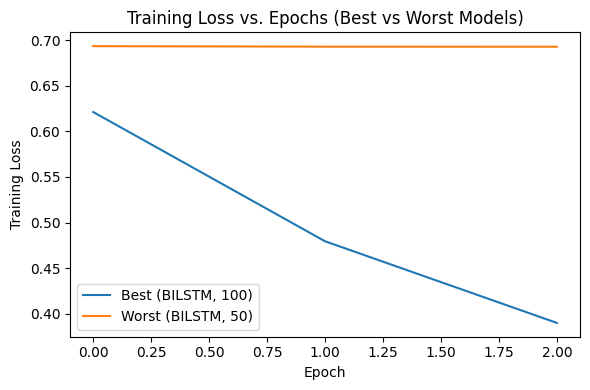

In [72]:
import matplotlib.pyplot as plt

best_idx = results_df_final["F1"].idxmax()
worst_idx = results_df_final["F1"].idxmin()

best_losses = losses_dict[best_idx]
worst_losses = losses_dict[worst_idx]

plt.figure(figsize=(6,4))
plt.plot(best_losses, label=f"Best ({results_df.loc[best_idx, 'Model']}, {results_df.loc[best_idx, 'Seq Length']})")
plt.plot(worst_losses, label=f"Worst ({results_df.loc[worst_idx, 'Model']}, {results_df.loc[worst_idx, 'Seq Length']})")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epochs (Best vs Worst Models)")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/loss_curves_best_worst.png")
plt.show()

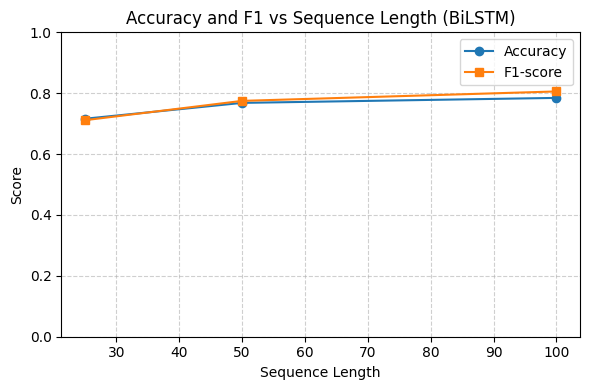

In [74]:
seq_experiment = results_df.iloc[9:12].copy()
seq_experiment = seq_experiment.sort_values(by="Seq Length")

plt.figure(figsize=(6,4))
plt.plot(seq_experiment["Seq Length"], seq_experiment["Accuracy"], marker='o', label="Accuracy")
plt.plot(seq_experiment["Seq Length"], seq_experiment["F1"], marker='s', label="F1-score")

plt.title("Accuracy and F1 vs Sequence Length (BiLSTM)")
plt.xlabel("Sequence Length")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Save plot
plt.savefig("/content/drive/MyDrive/acc_f1_vs_seq_length.png", dpi=300)
plt.show()

In [79]:
from tabulate import tabulate
print(tabulate(results_df_final, headers='keys', tablefmt='grid', showindex=False))

+---------+--------------+-------------+--------------+-----------------+------------+--------+------------------+
| Model   | Activation   | Optimizer   |   Seq Length |   Grad Clipping |   Accuracy |     F1 |   Epoch Time (s) |
+=========+==============+=============+==============+=================+============+========+==================+
| RNN     | Relu         | Adam        |           50 |             nan |     0.5934 | 0.5644 |             20.2 |
+---------+--------------+-------------+--------------+-----------------+------------+--------+------------------+
| LSTM    | Relu         | Adam        |           50 |             nan |     0.7523 | 0.7555 |             20.3 |
+---------+--------------+-------------+--------------+-----------------+------------+--------+------------------+
| BILSTM  | Relu         | Adam        |           50 |             nan |     0.7681 | 0.7705 |             21.5 |
+---------+--------------+-------------+--------------+-----------------+-------